## Name : Ezekiel Dong
## Topic : Finding the Sersic profile and Density Profile of Galaxy

In [1]:
#importing modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules from previou class
from ReadFile import Read
from MassProfile import MassProfile
from CenterOfMass2 import CenterOfMass
from GalaxyMass import ComponentMass
# the class CenterOfMass is not written by me, it's from anothor of my class
# The code I build for this class is the sersic function and following.

In [2]:
class TotalMass:
    # That's the code I am building for this class
    def __init__(self, snap_number_M31, snap_number_MW):
        # Create instances for MassProfile class for M31 and MW
        self.Mass_M31 = MassProfile("M31", snap_number_M31)
        self.Mass_MW = MassProfile("MW", snap_number_MW)

        # Read data for M31
        self.time, self.total, self.data = Read("M31_000.txt")
        self.M_31 = self.data['m'] * u.Msun
        self.x_31 = self.data['x'] * u.kpc
        self.y_31 = self.data['y'] * u.kpc
        self.z_31 = self.data['z'] * u.kpc

        # Read data for MW
        self.time_MW, self.total_MW, self.data_MW = Read("MW_000.txt")
        self.M_MW = self.data_MW['m'] * u.Msun
        self.x_MW = self.data_MW['x'] * u.kpc
        self.y_MW = self.data_MW['y'] * u.kpc
        self.z_MW = self.data_MW['z'] * u.kpc

        # Combine particle data of M31 and MW to simulate merger
        self.M_MW_M31 = np.append(self.M_31, self.M_MW)
        self.x_MW_M31 = np.append(self.x_MW, self.x_31)
        self.y_MW_M31 = np.append(self.y_MW, self.y_31)
        self.z_MW_M31 = np.append(self.z_MW, self.z_31)

    def Massenclosed(self, ptype, r_0, r_f, n):
        com = CenterOfMass("M31_000.txt", 2)
        com_pos = com.COM_P(0.1, 2.0)
        index = np.where(self.data['type'] == ptype)
        
        # Finding CenterOfMass for remnant.
        xG = self.x_MW_M31[index] - com_pos[0]
        yG = self.y_MW_M31[index] - com_pos[1]
        zG = self.z_MW_M31[index] - com_pos[2]
        rG = np.sqrt(xG**2 + yG**2 + zG**2)
        mG = self.M_MW_M31[index]
        mG = mG.value
        
        # Let radii increase by a small amount every iteration (delta r) 
        # from r_0 kpc to r_f kpc. Thus giving a small change instead of 
        # taking the whole radius.
        radii = np.linspace(r_0, r_f, n)
        m_enc = np.zeros(np.size(radii))
        density_r = np.zeros(np.size(radii - 1))
        
        for i, radius in enumerate(radii[:-1]):
            indexR = np.where((rG >= radius * u.kpc) & (rG <= radii[i + 1] * u.kpc))
            m_enc[i] = np.sum(mG[indexR])
            shell_area = 4 * np.pi * radius ** 2  # Surface area of the shell
            density = m_enc[i] / shell_area  # Density in the shell
            density_r[i + 1] = density
    
        return (density_r * (1e10 * u.Msun / u.pc**3))

    def sersicE(self, r, re, n, mtot):
        #Total luminosity
        lum = mtot
        #Effective surface brightness is
        Ie = lum/7.2/np.pi/re**2
        a = (r/re)**(1.0/n)
        b = -7.67*(a-1)
        # The surface brightness
        I = Ie*np.exp(-7.67*((r/re)**(1.0/n)-1.0))
        I = Ie*np.exp(b)
        return I

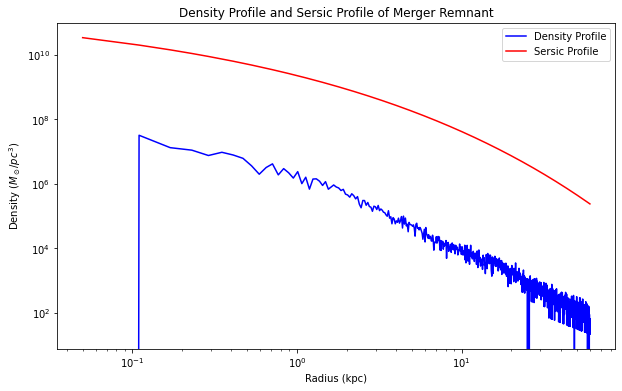

In [3]:
tm = TotalMass(snap_number_M31=0, snap_number_MW=0) 

ptype = 3  # Choose desired particle type (1 for dark matter, 2 for gas, and 3 for stars)
r_0 = 0.05
r_f = 60
n = 1000
density_r = tm.Massenclosed(ptype, r_0, r_f, n)

r = np.linspace(r_0, r_f, n)
re = 5  # Example value for effective radius, adjust as needed
sersic_index = 4  # Example value for Sersic index, adjust as needed
total_stellar_mass = 1e11  # Example value for total stellar mass, adjust as needed
sersic_profile = tm.sersicE(r, re, sersic_index, total_stellar_mass)

plt.figure(figsize=(10, 6))

plt.plot(r, density_r, label='Density Profile', color='blue')
plt.plot(r, sersic_profile, label='Sersic Profile', color='red')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Radius (kpc)')
plt.ylabel('Density ($M_\odot/pc^3$)')
plt.legend()
plt.title('Density Profile and Sersic Profile of Merger Remnant')

plt.show()